In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model  # Import für load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    

In [6]:


model_path_1 = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_200_trainingsbilder_noch_komplexer_early_stop_and_droput_3.h5'
model_path_2 = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'
input_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/Alle BA Sphäaeroidbilder sortiert'
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher/'
excel_file_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser neu2.xlsx'
excel_output_path_1 = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser Liste mit dropout 3.xlsx'
image_folder_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'

# Skalierungsfaktoren
scale_factor_width = 1296 / 256
scale_factor_height = 966 / 196


In [18]:


# Bilder laden und vorverarbeiten



def load_and_preprocess_image_pillow(img_path):                                                 #wenn 196,256 dann ist die genaugigkeit besser??
    img = Image.open(img_path).convert('L')  # Konvertiere zu Graustufen
    img = img.resize((256, 196))  # Größe anpassen
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    return img

def load_data(image_folder_path, excel_path):
    # Liste der Bilder im Ordner (wir nehmen an, sie sind bereits sortiert)
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    
    # Überprüfen, ob Bilder vorhanden sind
    if len(image_files) == 0:
        raise ValueError("Keine Bilddateien gefunden. Überprüfe den Pfad und das Verzeichnis.")
    
    # Lade und normalisiere die Bilder
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_folder_path, image_file)
        img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    
    X = np.array(images)
    
    # Lade die handgemessenen Daten
    manual_data = pd.read_excel(excel_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen, ob die Anzahl der Bilder mit den handgemessenen Werten übereinstimmt
    if len(image_files) != len(manual_measurements):
        raise ValueError("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")
    
    y = np.array(manual_measurements)
    
    # Aufteilung der Daten in Trainings- und Testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Liste aller Bilddateien im Verzeichnis
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.tif', '.png', '.jpg'))]

# Laden und Vorverarbeiten der Bilder
images = []
for filename in image_files:
    img_path = os.path.join(input_dir, filename)
    image = load_and_preprocess_image_pillow(img_path)  # Korrekte Übergabe des Pfads
    if image is not None:
        images.append(image)

print(f"Anzahl der geladenen Bilder: {len(images)}")
if len(images) > 0:
    print(f"Form des ersten Bildes: {images[0].shape}")


Anzahl der geladenen Bilder: 357
Form des ersten Bildes: (196, 256)


In [8]:
#Modelle laden 
model1 = tf.keras.models.load_model(model_path_1)
model2 = tf.keras.models.load_model(model_path_2)

In [9]:
#excel daten laden
predicted_diameters = []
df_manual = pd.read_excel(excel_file_path, header=0)  
manual_diameters = df_manual.iloc[:, 1].tolist()  

In [12]:
# Vorhersagen mit den Modellen
def predict_with_model(model1, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model1.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

def predict_image(image_path, model2):
    img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model2.predict(img_array)
    return prediction[0][0]

In [10]:
#Funktionen
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# Laden und Vorverarbeiten der Bilder mit Pillow


# Funktion zur Berechnung der mittleren Konturgröße
def calculate_average_contour_size(contour):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return cv2.contourArea(contour) / perimeter

# Funktion zur Auswahl des besten Schwellenwerts
def find_best_threshold(mask):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.1, 0.5, 0.01):
        binary_mask = (mask > threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            avg_size = calculate_average_contour_size(largest_contour)
            score = avg_size  # Anpassen der Bewertungsmetrik nach Bedarf

            if score > best_score:
                best_score = score
                best_threshold = threshold

    return best_threshold



In [19]:
### Vorhersage mit Modell 1

model = tf.keras.models.load_model(model_path_1)

# Listen für die berechneten Durchmesser und die manuell gemessenen Durchmesser
manual_diameters = []
predicted_diameters = []  

# Iteration über alle TIFF-Dateien im Eingabeordner
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Debug-Ausgabe: Anzahl der TIFF-Dateien
print(f"Anzahl der TIFF-Dateien: {len(tif_files)}")

# Überprüfen, ob die Anzahl der Dateien mit der Anzahl der manuellen Messungen übereinstimmt
if len(tif_files) != len(df_manual):
    print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
else:
    for i, filename in enumerate(tif_files):
        img_path = os.path.join(input_dir, filename)
        
        try:
            # Bild laden und vorverarbeiten
            image = load_and_preprocess_image_pillow(img_path)                          #bilder laden und vorberarbeten   
            # Vorhersage mit dem Modell machen
            predicted_mask = predict_with_model(model, image)                              #vorhersage mit model 1
            if predicted_mask is None:
                print(f"Fehler bei der Vorhersage für {filename}.")
                continue

            # Besten Schwellenwert für Konturen finden
            best_threshold = find_best_threshold(predicted_mask)                            #Threshhold für die Maske verstellen

            # Maske mit dem besten Schwellenwert erstellen
            binary_mask = (predicted_mask > best_threshold).astype(np.uint8) * 255  #Binäre maske mit bbestem schwellenwert finden
            
         
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)       #konturen finden

            if not contours:
                print(f"Keine Konturen im Bild {filename} gefunden.")
                continue

            # Filtere Konturen nach Schmalheitsverhältnis
            filtered_contours = []              #alle konturen auflisten und falsche herausfiltern (klappt nicht so gut?)
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:
                    continue
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                if circularity > 0.5:  # Anpassen des Schmalheitsverhältnisses nach Bedarf
                    filtered_contours.append(contour)

            if not filtered_contours:
                print(f"Keine geeigneten Konturen im Bild {filename} gefunden.")
                continue

            # Die größte Kontur nach dem Flächeninhalt finden
            largest_contour = max(filtered_contours, key=cv2.contourArea) #nur mit der größten kontur weiterarbeiten    

            # Berechne den Schwerpunkt der Kontur
            M = cv2.moments(largest_contour)
            if M["m00"] == 0:
                print(f"Schwerpunkt konnte im Bild {filename} nicht berechnet werden.")
                continue
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            # Berechne den mittleren Durchmesser der größten kontur
            avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
            avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width)              #umrechnen in mikrometer

            # Berechnung des Flächeninhalts
            area_pixels = cv2.contourArea(largest_contour)
            area_micrometers = area_pixels * (0.3745 * scale_factor_width * 0.3745 * scale_factor_height)           #umrechnen in mikrometer

            # Debug-Ausgabe: Überprüfen, wie oft der Wert hinzugefügt wird
            print(f"Vor dem Hinzufügen - Bild {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm")

            # Ergebnisse hinzufügen
            predicted_diameters.append(avg_diameter_micrometers)                #vorhergesagte durchmesser hinzufügen
            manual_diameters.append(df_manual.iloc[i, 0])  # Manuell gemessener Durchmesser hinzufügen wird glaub ich öfters gemacht(?)

            # Debug-Ausgabe nach dem Hinzufügen
            print(f"Nach dem Hinzufügen: {len(predicted_diameters)} vorhergesagte Durchmesser.")

            # Ausgabepfad für das segmentierte Bild definieren
            output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
            # Maske als TIFF-Datei speichern
            Image.fromarray(binary_mask, mode='L').save(output_path)                #binäre masken mit schwellenwert speichern
            print(f"Segmentiertes Bild für {filename} wurde gespeichert.")

            # Ergebnisse ausgeben
            print(f"Bild: {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm, Flächeninhalt: {area_micrometers:.2f} µm²")

        except Exception as e:
            print(f"Fehler bei der Verarbeitung von {filename}: {e}")

    # Debug-Ausgabe: Anzahl der erfolgreichen Vorhersagen und manuell gemessenen Durchmesser
    print(f"Anzahl der erfolgreichen Vorhersagen: {len(predicted_diameters)}")
    print(f"Anzahl der zugehörigen manuellen Durchmesser: {len(manual_diameters)}")

    # Ergebnisse in ein DataFrame konvertieren
    df_results = pd.DataFrame({                         #predicted diameters und manuell gemessene diameters in ein dataframe speichern
        'Manuell gemessene Durchmesser (µm)': manual_diameters,
        'Vorhergesagte Durchmesser (µm)': predicted_diameters
    })

    # Ergebnisse in eine Excel-Datei exportieren                            als excel datei speichern
    df_results.to_excel(excel_output_path_1, index=False)




    #Vorhersage mit Modell 2




def make_predictions(model_path_2, image_folder_path):
    # Modell laden
    model = load_model(model_path_2)

    # Vorhersagen für alle Bilder im Ordner
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    predictions = [predict_image(os.path.join(image_folder_path, image_file), model) for image_file in image_files]
    
    return np.array(predictions)
predictions = make_predictions(model_path_2, image_folder_path)


Anzahl der TIFF-Dateien: 357
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Vor dem Hinzufügen - Bild 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 159.46 µm
Nach dem Hinzufügen: 1 vorhergesagte Durchmesser.
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 C6_ch00.tif wurde gespeichert.
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 159.46 µm, Flächeninhalt: 19580.72 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
Vor dem Hinzufügen - Bild 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 D6_ch00.tif, Durchmesser: 161.25 µm
Nach dem Hinzufügen: 2 vorhergesagte Durchmesser.
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 D6_ch00.tif wurde gespeichert.
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 D6_ch00.tif, Durchmesser: 161.25 µm, Flächeninhalt: 20018.14 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
Vor dem Hinzufügen - Bild 001_CQ Sphaeroide Tag 0 belichtet_2,5% + A

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━

Anzahl der Vorhersagen (Predictions 1): 357
Anzahl der Vorhersagen (Predictions 2): 357
Anzahl der handgemessenen Werte: 357

Metriken zur Bewertung der Modellgenauigkeit (Predictions 1):
MAE (Mean Absolute Error): 2.07 µm
MSE (Mean Squared Error): 11.75 µm²
R2 Score (Coefficient of Determination): 0.99

Metriken zur Bewertung der Modellgenauigkeit (Predictions 2):
MAE (Mean Absolute Error): 11.27 µm
MSE (Mean Squared Error): 208.63 µm²
R2 Score (Coefficient of Determination): 0.89


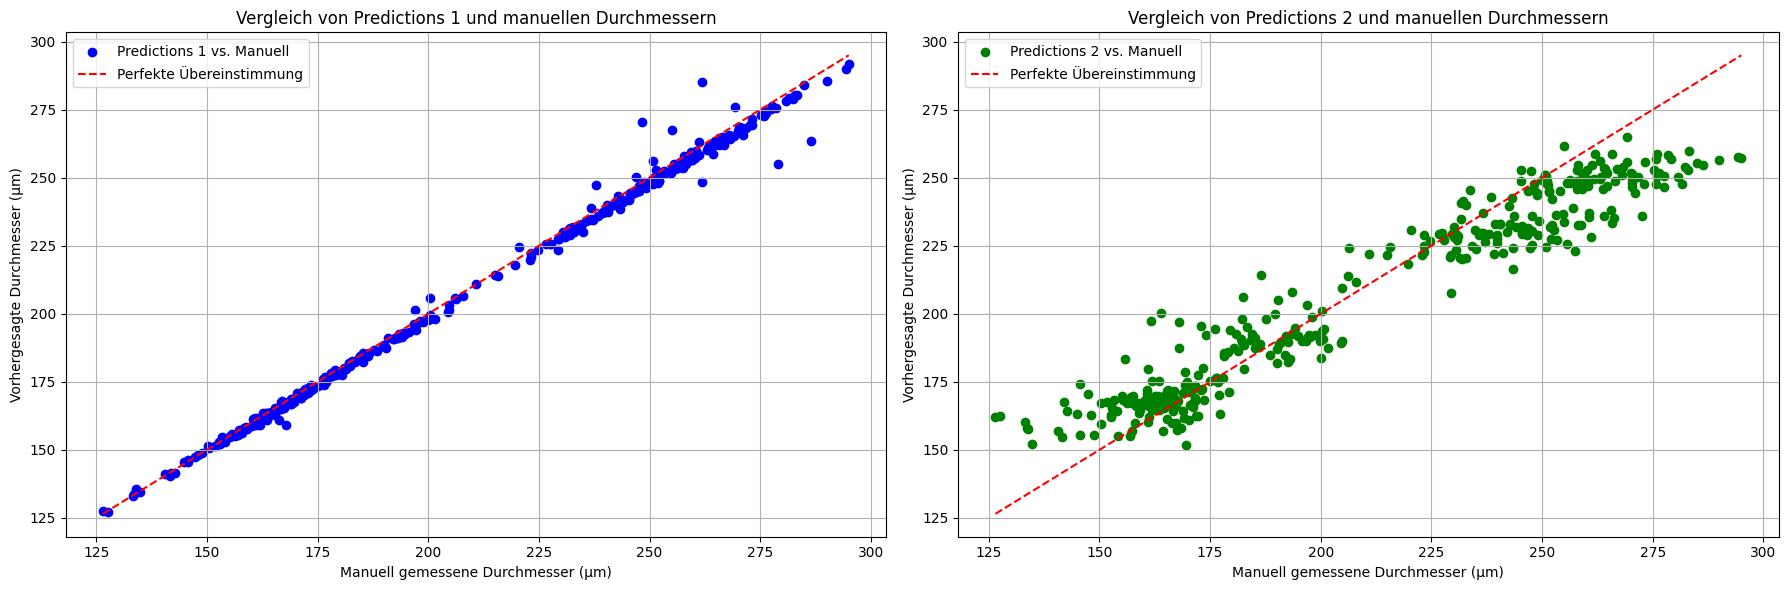

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(predicted_diameters, predictions, manual_data_path, output_image_path):
    # Lade die handgemessenen Werte
    manual_data = pd.read_excel(manual_data_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values

    # Überprüfen der Anzahl der Vorhersagen und der manuellen Werte
    print(f"Anzahl der Vorhersagen (Predictions 1): {len(predicted_diameters)}")
    print(f"Anzahl der Vorhersagen (Predictions 2): {len(predictions)}")
    print(f"Anzahl der handgemessenen Werte: {len(manual_measurements)}")

    if len(predicted_diameters) == len(manual_measurements) and len(predictions) == len(manual_measurements):
        # Berechnung der Metriken zur Bewertung der Modellgenauigkeit für beide Vorhersagen
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        mse = mean_squared_error(manual_diameters, predicted_diameters)
        r2 = r2_score(manual_diameters, predicted_diameters)
        
        mae_2 = mean_absolute_error(manual_measurements, predictions)
        mse_2 = mean_squared_error(manual_measurements, predictions)
        r2_2 = r2_score(manual_measurements, predictions)

        print(f"\nMetriken zur Bewertung der Modellgenauigkeit (Predictions 1):")
        print(f"MAE (Mean Absolute Error): {mae:.2f} µm")
        print(f"MSE (Mean Squared Error): {mse:.2f} µm²")
        print(f"R2 Score (Coefficient of Determination): {r2:.2f}")

        print(f"\nMetriken zur Bewertung der Modellgenauigkeit (Predictions 2):")
        print(f"MAE (Mean Absolute Error): {mae_2:.2f} µm")
        print(f"MSE (Mean Squared Error): {mse_2:.2f} µm²")
        print(f"R2 Score (Coefficient of Determination): {r2_2:.2f}")

        # Erstellen der Subplots
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        
        # Scatterplot für Predictions 1
        axs[0].scatter(manual_measurements, predicted_diameters, color='blue', label='Predictions 1 vs. Manuell')
        axs[0].plot([min(manual_measurements), max(manual_measurements)], 
                    [min(manual_measurements), max(manual_measurements)], 
                    color='red', linestyle='--', label='Perfekte Übereinstimmung')
        axs[0].set_xlabel('Manuell gemessene Durchmesser (µm)')
        axs[0].set_ylabel('Vorhergesagte Durchmesser (µm)')
        axs[0].set_title('Vergleich von Predictions 1 und manuellen Durchmessern')
        axs[0].legend()
        axs[0].grid(True)
        
        # Scatterplot für Predictions 2
        axs[1].scatter(manual_measurements, predictions, color='green', label='Predictions 2 vs. Manuell')
        axs[1].plot([min(manual_measurements), max(manual_measurements)], 
                    [min(manual_measurements), max(manual_measurements)], 
                    color='red', linestyle='--', label='Perfekte Übereinstimmung')
        axs[1].set_xlabel('Manuell gemessene Durchmesser (µm)')
        axs[1].set_ylabel('Vorhergesagte Durchmesser (µm)')
        axs[1].set_title('Vergleich von Predictions 2 und manuellen Durchmessern')
        axs[1].legend()
        axs[1].grid(True)
        
        # Layout anpassen und speichern
        plt.tight_layout()
        plt.savefig(output_image_path)
        plt.show()
    else:
        print("Die Anzahl der Vorhersagen stimmt nicht mit der Anzahl der handgemessenen Werte überein.")

# Beispielaufruf der Funktion
manual_data_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser neu2.xlsx'
output_image_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/scatterplots_neu.png'

# Angenommen, predicted_diameters und predictions sind bereits berechnete Vorhersagen
evaluate_model(predicted_diameters, predictions, manual_data_path, output_image_path)
